### $\color{magenta}{\text{DISAMBIGUATION - TEST $3$ }} $

In [1]:
import numpy as np
import numpy.ma as ma
import time
from matplotlib.transforms import Affine2D
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import astropy.io.fits as fits
import math
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter
from acute_angle_method import acute_angle_method
import re

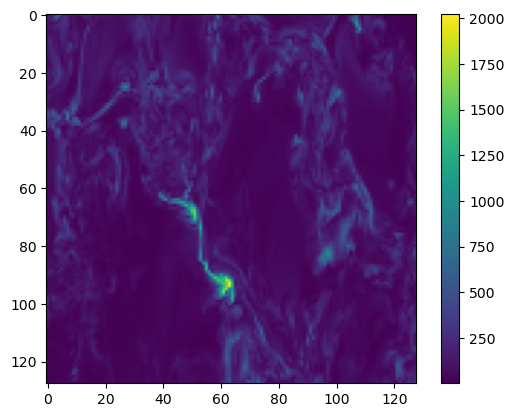

In [7]:
atmos = fits.open('pole_atmosphere.fits')[0].data[:,15,:128,:128]
atmos.shape
B, az, inc = atmos[4], np.radians(atmos[6]), np.radians(atmos[7])

Bx = B * np.cos(az) * np.sin(inc)
By = B * np.sin(az) * np.sin(inc)
Bz = B * np.cos(inc)

plt.imshow(B)
plt.colorbar()
plt.show()

In [8]:
Bx_ambig, By_ambig, az_ambig = Bx.copy(), By.copy(), az.copy()
flip_prob = 0.5
flip_mask = (np.random.rand(*Bx_ambig.shape) < flip_prob)

Bx_ambig[flip_mask] *= -1
By_ambig[flip_mask] *= -1
az_ambig[flip_mask] *= -1
Btr_ambig = np.sqrt(Bx_ambig**2 + By_ambig**2)

In [46]:
from MEM_pole import MinimumEnergyDisambiguator

start = time.time()

disambig = MinimumEnergyDisambiguator(Bx_ambig, By_ambig, Bz, 
                                 dx = 1.0, dy = 1.0,
                                 lambda_factor = 1.0, B_threshold = 100,
                                 pad_width=50, tfactr=0.95, tfac0=0.1, neq=200,
                                 geometry='polar', theta=65, phi=0, 
                                 p_angle=0, b_angle=0)

disambig.simulated_annealing(max_iter=500)
#disambig.acute_angle(Bx_threshold=200, By_threshold=200)
disambig.save_disambiguation_results()

end = time.time()
print('Time to disambiguate FOV: {:.2f} s'.format(end - start))

Annealing iterations:   8%|█▌                  | 40/500 [00:26<04:59,  1.53it/s]

Final energy = 965404.2932901857
Final temperature = 21.89327445152648
Total iterations = 41
Minimum energy disambiguation results saved!
Time to disambiguate FOV: 26.70 s


In [12]:
Bx_mem = fits.open('MEM_disambiguation_results_pole.fits')[0].data 
By_mem = fits.open('MEM_disambiguation_results_pole.fits')[1].data
az_mem = fits.open('MEM_disambiguation_results_pole.fits')[2].data
Jz_mem = fits.open('MEM_disambiguation_results_pole.fits')[3].data

Btr_mem = np.sqrt(Bx_mem**2 + By_mem**2)

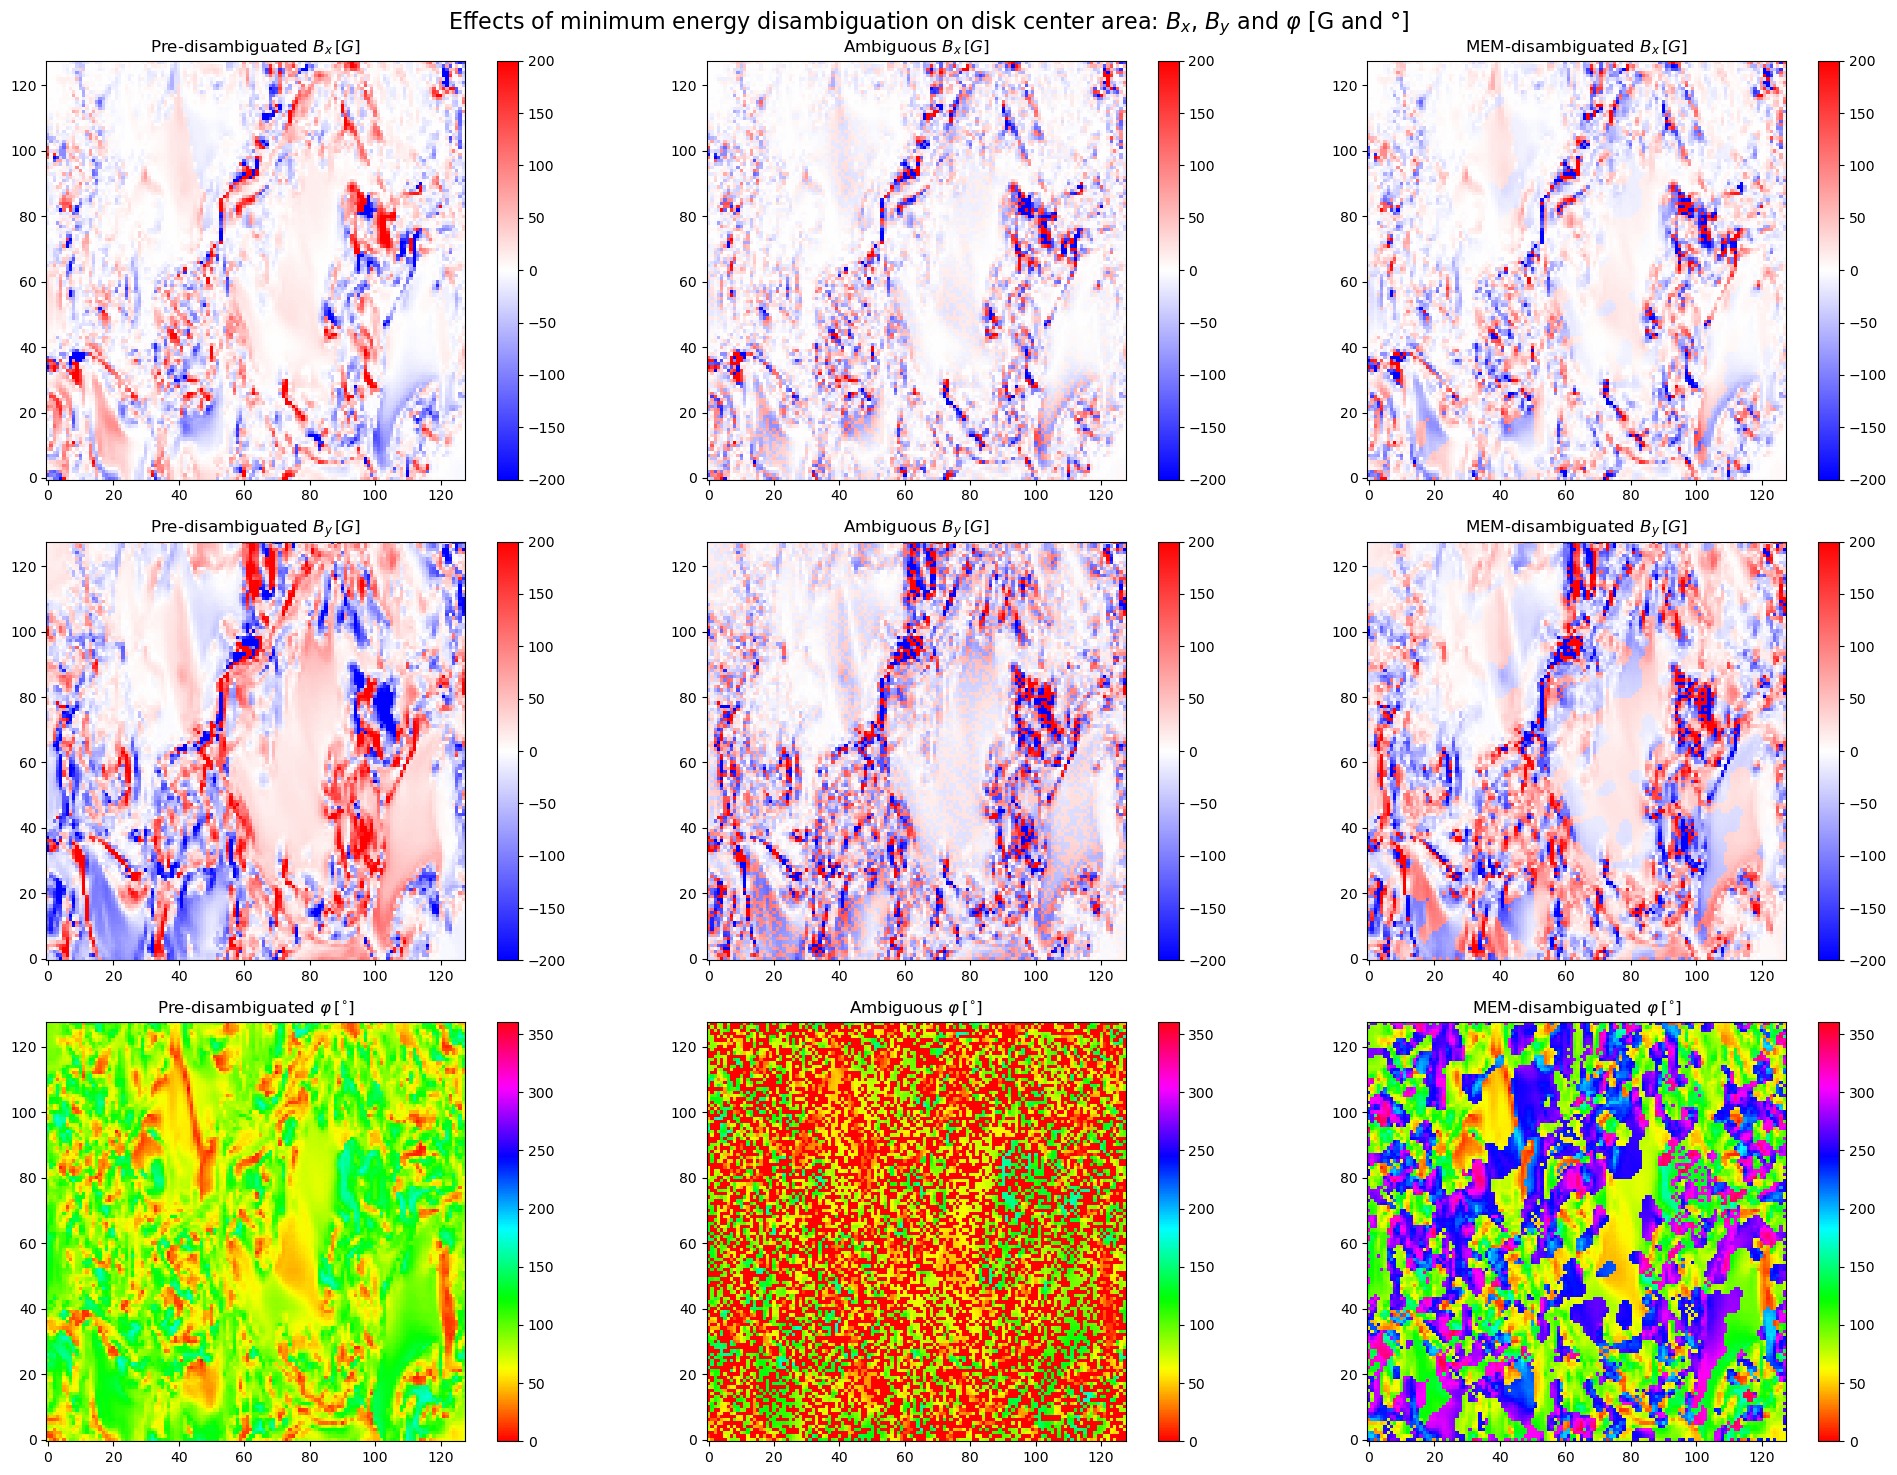

In [14]:
plots = [Bx, Bx_ambig, Bx_mem, 
         By, By_ambig, By_mem, 
         np.degrees(az), np.degrees(az_ambig), az_mem]

titles = [r'Pre-disambiguated $B_x\,[G]$',  
          r'Ambiguous $B_x\,[G]$',
          r'MEM-disambiguated $B_x\,[G]$', 
          r'Pre-disambiguated $B_y\,[G]$',
          r'Ambiguous $B_y\,[G]$',
          r'MEM-disambiguated $B_y\,[G]$',
          r'Pre-disambiguated $\varphi\,[^{\circ}]$',
          r'Ambiguous $\varphi\,[^{\circ}]$',
          r'MEM-disambiguated $\varphi\,[^{\circ}]$']

fig, axes = plt.subplots(3, 3, figsize=(20, 15)) 

for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax = axes[i, j]
        if i == 2:
            vmin, vmax = 0, 360
            cmap = 'hsv'
        else:
            vmin, vmax = -200, 200
            cmap = 'bwr'
        im = ax.imshow(plots[idx], origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(titles[idx])
        fig.colorbar(im, ax=ax)

plt.suptitle(r'Effects of minimum energy disambiguation on disk center area: $B_x$, $B_y$ and $\varphi$ [G and °]', 
             fontsize=16)
plt.tight_layout()
plt.show()